# Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
dfTest = pd.read_csv("data/UJIndoorLoc_validationData.csv")

In [3]:
"""
    dfTrain.columns
    -------------------------------
    'WAP001', ..., 'WAP520', 
    'LONGITUDE', 'LATITUDE', 
    'FLOOR', 'BUILDINGID', 'SPACEID', 
    'RELATIVEPOSITION', 
    'USERID', 'PHONEID', 'TIMESTAMP'
    
    19937 rows, 529 columns
"""
print('\n- BUILDINGID')
display(dfTrain.BUILDINGID.value_counts())
print('\n- FLOOR')
display(dfTrain.FLOOR.value_counts())
print('\n- RELATIVEPOSITION')
display(dfTrain.RELATIVEPOSITION.value_counts())
print('\n- SPACEID')
display(dfTrain.SPACEID.nunique())
print('\n- PHONEID')
display(dfTrain.PHONEID.unique())
print('\n- USERID')
display(dfTrain.USERID.unique())
print('\n- Shape dfTrain')
dfTrain.shape


- BUILDINGID


2    9492
0    5249
1    5196
Name: BUILDINGID, dtype: int64


- FLOOR


3    5048
1    5002
2    4416
0    4369
4    1102
Name: FLOOR, dtype: int64


- RELATIVEPOSITION


2    16608
1     3329
Name: RELATIVEPOSITION, dtype: int64


- SPACEID


123


- PHONEID


array([23, 13, 16, 18,  3, 19,  6,  1, 14,  8, 24, 17,  7, 11, 22, 10])


- USERID


array([ 2, 11,  3,  4,  5,  6,  7,  8,  9, 16, 10, 12, 13, 14, 15,  1, 17,
       18])


- Shape dfTrain


(19937, 529)

## Deal not consistent data

In [4]:
"""
dfF = dfTrain[dfTrain.columns.values[0:520]]==100
dfF[dfF[dfTrain.columns.values[0:520]]==100].shape
#dfTrain.groupby('PHONEID').BUILDINGID.nunique() # nunique
"""
wifiSens = 520
dfTemp = dfTrain[dfTrain.columns.values[0:wifiSens]]

# drop columns (all rows in a column = 100, dont make any significance)
wa_columns = pd.DataFrame(dfTemp.sum(axis=0) == dfTrain.shape[0]*100, columns=['isOut'])
wa_columns = wa_columns[wa_columns['isOut']==False].T.columns.values
new_columns = list(wa_columns) + list(dfTrain.columns.values[wifiSens:])
dfTrain = dfTrain[new_columns]

# drop rows (all columns = 100 with different spaceId, buildingId, floorId)
dfTrain = dfTrain[dfTemp.sum(axis=1)  != wifiSens * 100]

dfTrain.shape

(19861, 474)

In [5]:
pd.crosstab(dfTrain.FLOOR, dfTrain.BUILDINGID)

BUILDINGID,0,1,2
FLOOR,,,
0,1058,1368,1906
1,1356,1484,2161
2,1443,1396,1576
3,1391,911,2709
4,0,0,1102


In [6]:
# FLOOR RELATIVEPOSITION
pd.DataFrame(pd.crosstab(dfTrain.SPACEID, [dfTrain.BUILDINGID, dfTrain.FLOOR]).sum(axis=0), columns=['SPACEID_COUNT']).T

BUILDINGID        0                       1                      2        \
FLOOR             0     1     2     3     0     1     2    3     0     1   
SPACEID_COUNT  1058  1356  1443  1391  1368  1484  1396  911  1906  2161   

BUILDINGID                       
FLOOR             2     3     4  
SPACEID_COUNT  1576  2709  1102

In [7]:
dfTrain.LONGITUDE.describe()

count    19861.000000
mean     -7464.366550
std        123.499669
min      -7691.338400
25%      -7594.737000
50%      -7423.060900
75%      -7359.193000
max      -7300.818990
Name: LONGITUDE, dtype: float64

In [8]:
dfTrain.LATITUDE.describe()

count    1.986100e+04
mean     4.864871e+06
std      6.695601e+01
min      4.864746e+06
25%      4.864821e+06
50%      4.864852e+06
75%      4.864930e+06
max      4.865017e+06
Name: LATITUDE, dtype: float64

In [9]:
building_0 = dfTrain.loc[(dfTrain.BUILDINGID == 0)]
display(building_0.SPACEID.nunique())
building_0 = dfTrain.loc[(dfTrain.BUILDINGID == 1)]
display(building_0.SPACEID.nunique())
building_0 = dfTrain.loc[(dfTrain.BUILDINGID == 2)]
display(building_0.SPACEID.nunique())

78

86

97

## Buildings Distribution 

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker
import matplotlib as mpl
%matplotlib notebook

mpl.style.use('tableau-colorblind10')
mpl.rcParams['image.cmap'] = 'tab20'
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
# mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

import geopy.distance

def error_distance (inputDataFrame, x = ["LATITUDE", "PRED_LATITUDE"], y = ["LONGITUDE", "PRED_LONGITUDE"], z=["FLOOR", "PRED_FLOOR"])
    altura = 2.5
    real_point = (inputDataFrame[x[0]], inputDataFrame[y[0]])
    pred_point= (inputDataFrame[x[1]], inputDataFrame[y[1]])
    #https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    #https://en.wikipedia.org/wiki/Vincenty%27s_formulae
    var_xy = geopy.distance.vincenty(real_point, pred_point).m
    var_z = np.abs(inputDataFrame[z[0]] - inputDataFrame[z[1]]) * altura
    inputDataFrame['ERR_REG'] = var_xy
    inputDataFrame['ERR'] = np.sqrt(var_xy*var_xy + var_z*var_z)
    

def graphicMap2D(inputDataFrame, filename="test", x = "LATITUDE", y="LONGITUDE", hue="BUILDINGID"):
    sns.lmplot(x=x, y=y, hue=hue, data=inputDataFrame, fit_reg=False, x_jitter=.1, markers='.')
    plt.show()
    plt.savefig("images/"+str(filename)+".svg")

def graphicBuildings(inputDataFrame, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="test"):
    fig = plt.figure(figsize=(15,8))
    fig.tight_layout()
    for index in range(3):
        ax = fig.add_subplot(1, 3, index+1, projection='3d')
        fig.tight_layout()
        dfGraphics = inputDataFrame[inputDataFrame.BUILDINGID==index]
        x = dfGraphics[columns[0]]
        y = dfGraphics[columns[1]]
        z = dfGraphics[columns[2]]
        N = 6
        xmin, xmax = min(x), max(x)
        ymin, ymax = min(y), max(y)
        c = 4*dfGraphics.BUILDINGID + dfGraphics.FLOOR # colorSet
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.set_zlabel('Floor')
        ax.set_title('Building '+str(index))
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(0, 4)
        ax.set_yticks(np.round(np.linspace(ymin, ymax, N), 3))
        ax.set_xticks(np.round(np.linspace(xmin, xmax, N), 3))
        ax.set_zticks(np.int32(np.linspace(0, 4, 5)))
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        ax.view_init(10, 60)
        ax.scatter(x, y, z, c=c)
    plt.tight_layout()
    plt.show()
    plt.savefig("images/"+str(filename)+".svg")
    
def graphicMap3D(inputDataFrame, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="test"):
    fig = plt.figure(figsize=(15,8))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    fig.tight_layout()
    dfGraphics = inputDataFrame
    x = dfGraphics[columns[0]]
    y = dfGraphics[columns[1]]
    z = dfGraphics[columns[2]]
    N = 6
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    c = 4 * dfGraphics.BUILDINGID + dfGraphics.FLOOR
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Floor')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(0, 4)
    ax.set_yticks(np.round(np.linspace(ymin, ymax, N), 3))
    ax.set_xticks(np.round(np.linspace(xmin, xmax, N), 3))
    ax.set_zticks(np.int32(np.linspace(0, 4, 5)))
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.view_init(20, 50)
    ax.scatter(x, y, z, c=c)
    plt.tight_layout()
    plt.show()
    plt.savefig("images/"+str(filename)+".svg")

<IPython.core.display.Javascript object>


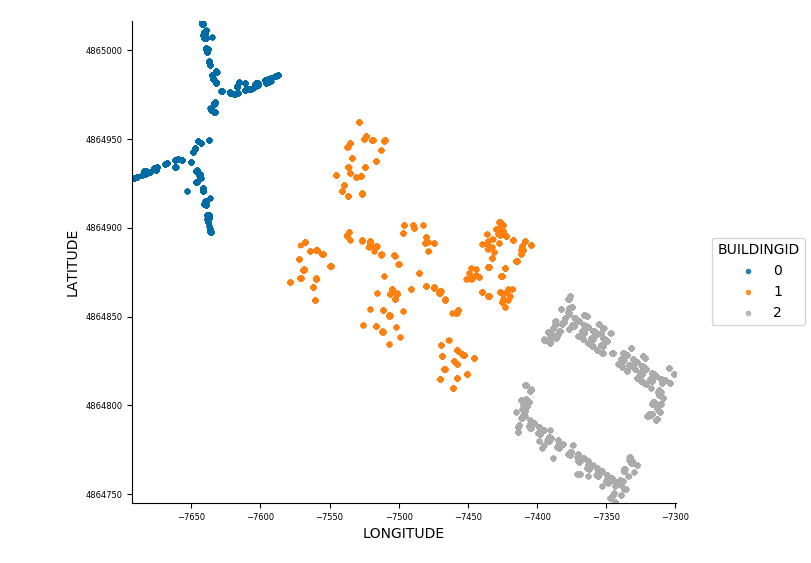

In [32]:
graphicMap2D(dfTrain, filename="buildingsMap2d",  x = "LONGITUDE", y="LATITUDE")

<IPython.core.display.Javascript object>


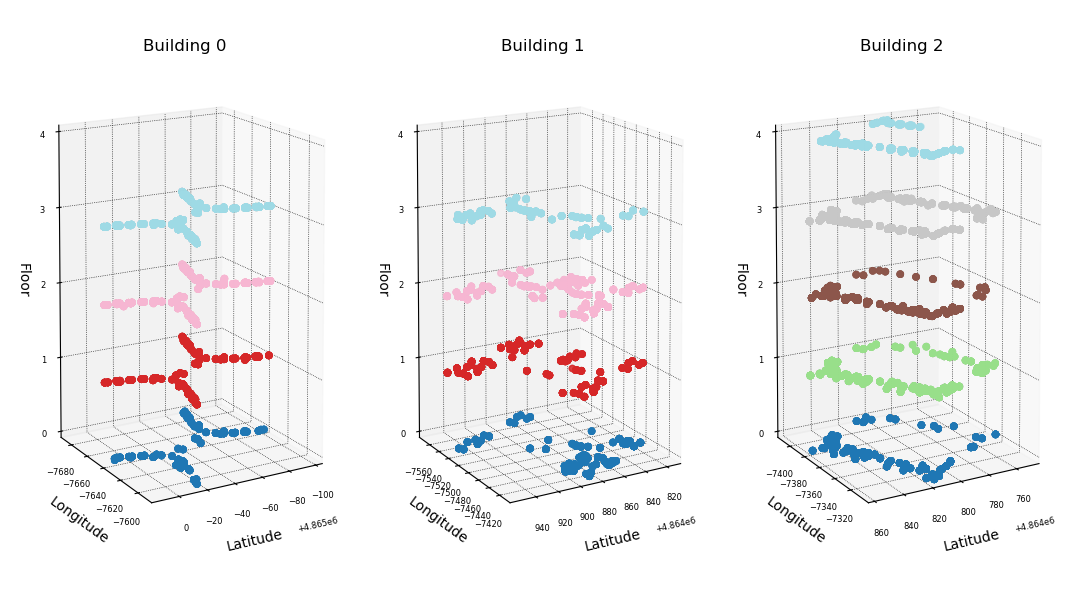

In [16]:
graphicBuildings(dfTrain, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsTrain")

<IPython.core.display.Javascript object>


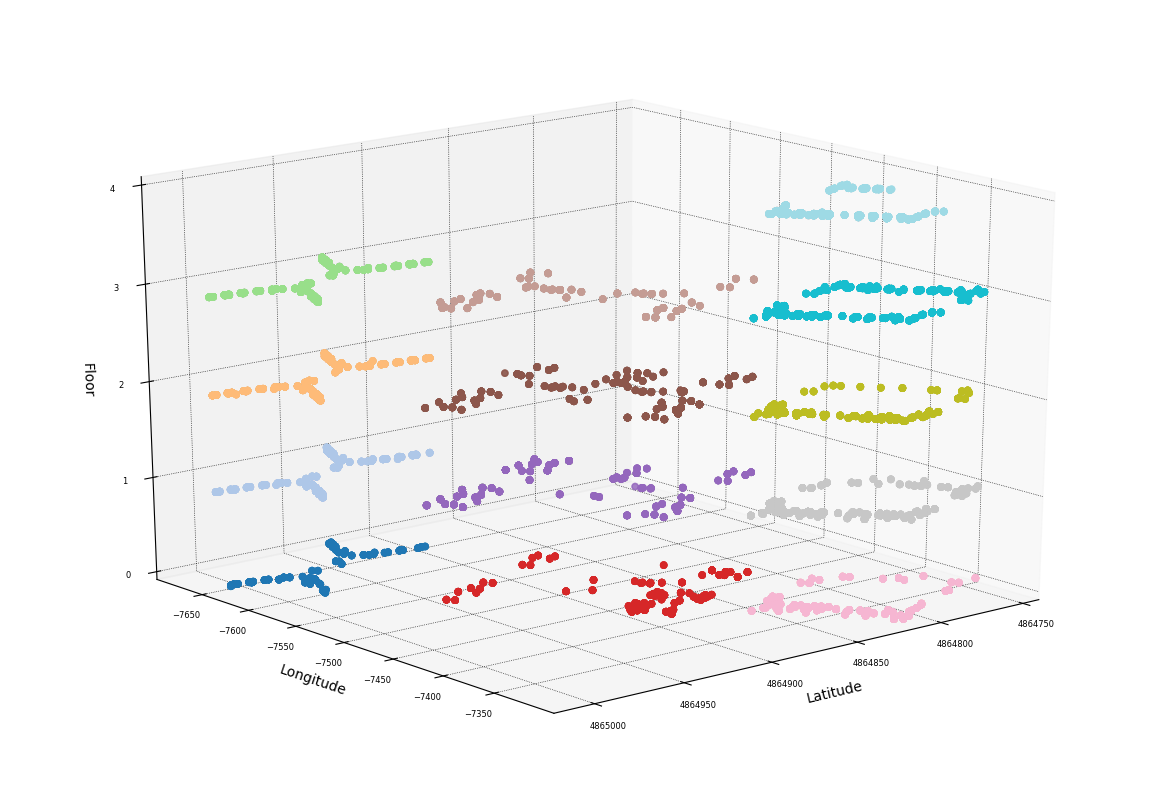

In [19]:
graphicMap3D(dfTrain, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3d")

## Mixed Prediction

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

seed = 7

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(dfTrain[list(wa_columns)], dfTrain['FLOOR'])
p_floor = model.predict(dfTest[list(wa_columns)])
display('Floor Classification Score')
display(model.score(dfTest[list(wa_columns)], dfTest['FLOOR']))

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(dfTrain[list(wa_columns)], dfTrain['BUILDINGID'])
p_building = model.predict(dfTest[list(wa_columns)])
display('Building Classification Score')
display(model.score(dfTest[list(wa_columns)], dfTest['BUILDINGID']))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(dfTrain[list(wa_columns)], dfTrain['LATITUDE'])
p_latitude = model.predict(dfTest[list(wa_columns)])
display('Latitude Regression Score')
display(model.score(dfTest[list(wa_columns)], dfTest['LATITUDE']))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(dfTrain[list(wa_columns)], dfTrain['LONGITUDE'])
p_longitude = model.predict(dfTest[list(wa_columns)])
display('Longitude Regression Score')
display(model.score(dfTest[list(wa_columns)], dfTest['LONGITUDE']))

# setting predicted values into dataframe
dfTest['PRED_FLOOR'] = p_floor
dfTest['PRED_BUILDING'] = p_building
dfTest['PRED_LATITUDE'] = p_latitude
dfTest['PRED_LONGITUDE'] = p_longitude

'Floor Classification Score'

0.8388838883888389

'Building Classification Score'

0.9972997299729973

'Latitude Regression Score'

0.9628875200679251

'Longitude Regression Score'

0.978721385109407

<IPython.core.display.Javascript object>


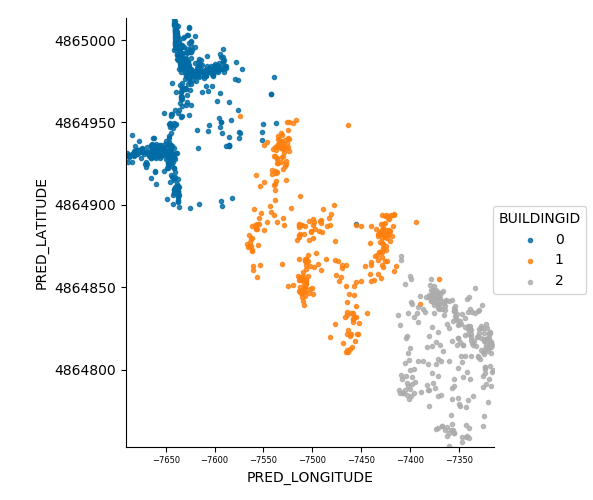

In [29]:
graphicMap2D(dfTest, filename="test", x = "PRED_LONGITUDE", y="PRED_LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


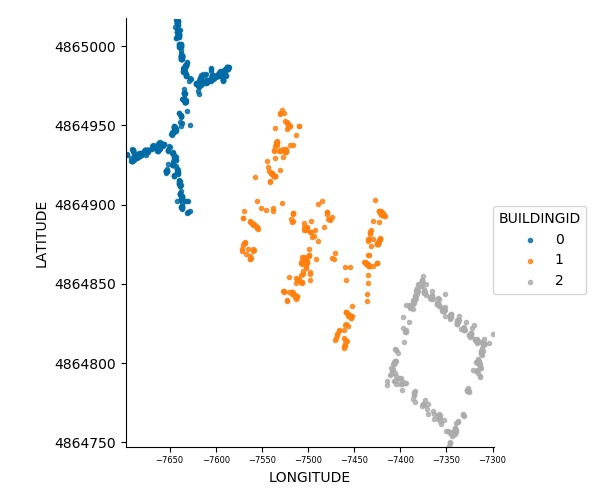

In [30]:
graphicMap2D(dfTest, filename="test", x = "LONGITUDE", y="LATITUDE", hue="BUILDINGID")

In [ ]:
# Multi Ouput Prediction
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor

multi_target_forest = MultiOutputClassifier(RandomForestClassifier(), n_jobs=-1)
multi_target_forest.fit(dfTrain[list(wa_columns)], dfTrain[['FLOOR', 'BUILDINGID']])
predicted = multi_target_forest.predict(dfTest[list(wa_columns)])
score = multi_target_forest.score(dfTest[list(wa_columns)], dfTest[['FLOOR', 'BUILDINGID']])
display(score)

regr_multirf = MultiOutputRegressor(RandomForestRegressor(), n_jobs=-1)
regr_multirf.fit(dfTrain[list(wa_columns)], dfTrain[['LATITUDE', 'LONGITUDE']])
predicted = regr_multirf.predict(dfTest[list(wa_columns)])
score = regr_multirf.score(dfTest[list(wa_columns)], dfTest[['LATITUDE', 'LONGITUDE']])
display(score)

In [ ]:
# Style sheets reference
# https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
# Style
# https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
# Color Maps
# https://matplotlib.org/tutorials/colors/colormaps.html
# Other References
# https://github.com/ohuarcaya/businessAnalytics/blob/master/compartamosFinanciera.ipynb
# https://es.stackoverflow.com/questions/163597/contar-cantidad-de-repeticiones-por-parejas-usando-pandas
# https://code.likeagirl.io/an%C3%A1lisis-y-visualizaci%C3%B3n-de-datos-con-pandas-matplotlib-85ee4d7b4cad

# https://matplotlib.org/gallery/pyplots/pyplot_scales.html
# https://seaborn.pydata.org/generated/seaborn.lmplot.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html

- Aplicar clean data on train
- Aplicar Feature selection
- pattern recognition / pattern mining
- compare models
- tune models (heuristics - metaheuristics)[benchmark]
- comparison and result models
- comparison and result benchmark 
